## Base de dados petr4
A base de dados pode ser encontrada [aqui](https://br.financas.yahoo.com/quote/PETR4.SA/history?p=PETR4.SA)
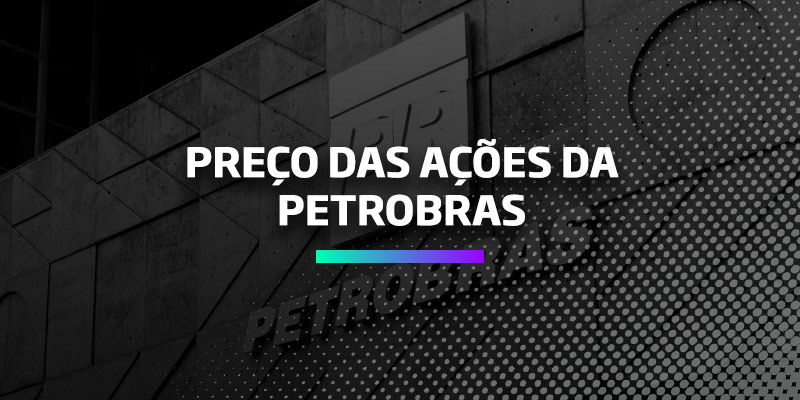

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('petr4_treinamento.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


Temos 7 colunas presentes no dataset fornecido, sendo 6 delas variáveis características (dados de entrada) e uma delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever).

As variáveis características são:

    Date         - Data da ação
    High         - Valor máximo do dia
    Low          - Valor mínimo do dia
    Close        - Valor de fechamento
    Adj Close    - Valor real
    Volume       - Volume de ação que foi negociado

A variável-alvo é:

    Open         - Por quanto a ação foi aberta

#### Tratando valores faltantes (NaN)

In [4]:
print("Valores nulos antes da transformação: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes da transformação: 

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64



Já que possuimos poucos dados com valores faltantes, iremos apenas apagá-los

In [5]:
df = df.dropna()

In [6]:
# Visualizando os dados faltantes do dataset após a terceira transformação
print("Valores nulos após a transformação: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos após a transformação: 

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64



#### Definindo as features do modelo

In [7]:
df_train = df.iloc[:, 1:7].values

#### Normalização dos dados da base de treinamento
Podemos observar que os nossos dados estão em escalas diferentes das demais, principalmente da coluna 'Volume', para isso iremos utilizar a função ``MinMaxScaler`` para realizar a normalização dos dados.

In [8]:
df.sample()

,Date,Open,High,Low,Close,Adj Close,Volume
211,2013-11-04,19.99,20.280001,19.950001,20.219999,18.925287,20508100.0


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
normalizador = MinMaxScaler(feature_range=(0, 1))
df_train_normalizado = normalizador.fit_transform(df_train)

###### Coletando os valores das datas anteriores
Para realizar a previsão do dia de 'hoje' precisamos pegar o valor real das 90 previsões dos dias anteriores, para isso criaremos um vetor com as 90 primeiras linhas do dataset.

    array previsores - ele receberá as primeiras 90 linhas para o treinamento
    array preco_real - ele receberá todos os preços reais da linha 90 até 1242

In [11]:
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(df_train_normalizado[i-90:i, 0:6])
    preco_real.append(df_train_normalizado[i, 0])

In [12]:
# transformação para o tipo 'Series'
previsores, preco_real = np.array(previsores), np.array(preco_real)

#### Redes Neurais Recorrentes
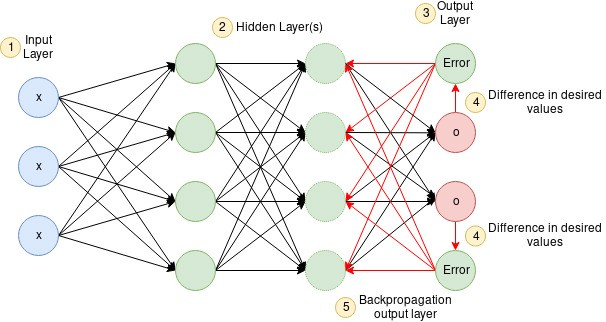

###### Importações
Para isso, utilizaremos a biblioteca ``keras``

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

###### Parâmetros da rede neural recorrente:
Link: https://keras.io/

    Sequential - Criação de uma nova rede neural
    units - Número de celulas de memória (ideal um valor maior para adicionar mais dimensionalidade ao decorrer do tempo)
    return_sequences - utilizado quando se tem 2 ou mais LSTM (onde passa a informação para as outras camadas subsequentes)
    input_shape - Configurações anteriores dos dados de entrada
    Dropout - é usado para diminuir a chance de overfitting (30% dos neurônios de entrada são zerados)
    
###### Parâmetros do otimizador

    optimizer - 'RMSPROP' bastante utilizado em redes neurais recorrentes
    loss - Função de perda (mean_squared_error pois é um problema de regressão)
    metrics - Métrica de avaliação (pode ser colocado mais de um)

In [1]:
regressor = Sequential()
# Camada de entrada
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))
# Camada oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
# Camada oculta 2
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))
# Camada de saída
regressor.add(Dense(units = 1, activation = 'sigmoid'))
# Otimizações
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

NameError: name 'Sequential' is not defined

###### Parâmetros callbacks
Link: https://keras.io/api/callbacks

###### Parâmetro 01 - EarlyStopping
Link: https://keras.io/api/callbacks/early_stopping/

Conjuntos de funções que podem ser aplicados em determinados estados do processo de treinamento.

Obs: O treinamento é parado quando uma função monitorada para de melhorar.

    monitor - Função a ser monitorada
    min_delta - Mudança minima que deve ser monitorada a ser considerada como melhoria
    patience - Número de épocas que deve ser seguido sem o resultado (caso passe desse número o treinamento é parado)

In [15]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)

###### Parâmetro 02 - ReduceLROnPlateau
https://keras.io/api/callbacks/reduce_lr_on_plateau/

Reduz a taxa de aprendizagem quando uma métrica para de melhorar

    monitor - Função a ser monitorada
    fator - fator pelo qual a taxa de aprendizagem será reduzida. new_lr = lr * factor.
    min_delta - Mudança minima que deve ser monitorada a ser considerada como melhoria
    patience - Número de épocas que deve ser seguido sem o resultado (caso passe desse número o treinamento é parado)

In [16]:
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)

###### Parâmetro 03 - ModelCheckPoint
https://keras.io/api/callbacks/model_checkpoint/

Esta classe é utilizada para a melhora dos resultados e ele salva o modelo a cada uma das épocas (passado como paramêtro)

    filepath - Caminho do arquivo a ser salvo
    monitor  - Função a ser monitorada
    save_best_only - Sempre salva o que obteve o melhor resultado

In [17]:
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', save_best_only = True, verbose = 1)

###### Treinamento do modelo

In [18]:
# treinamento
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32, callbacks = [es, rlr, mcp])

Epoch 1/100
36/36 [==============================] - 15s 150ms/step - loss: 0.0269 - mean_absolute_error: 0.1264

Epoch 00001: loss improved from inf to 0.01680, saving model to pesos.h5
Epoch 2/100
36/36 [==============================] - 5s 152ms/step - loss: 0.0061 - mean_absolute_error: 0.0620

Epoch 00002: loss improved from 0.01680 to 0.00539, saving model to pesos.h5
Epoch 3/100
36/36 [==============================] - 6s 155ms/step - loss: 0.0038 - mean_absolute_error: 0.0479

Epoch 00003: loss improved from 0.00539 to 0.00387, saving model to pesos.h5
Epoch 4/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0041 - mean_absolute_error: 0.0495

Epoch 00004: loss improved from 0.00387 to 0.00386, saving model to pesos.h5
Epoch 5/100
36/36 [==============================] - 6s 170ms/step - loss: 0.0029 - mean_absolute_error: 0.0424

Epoch 00005: loss improved from 0.00386 to 0.00282, saving model to pesos.h5
Epoch 6/100
36/36 [==============================] - 

Podemos observar que a cada época que o modelo melhora, ele continua pois estamos usando as funções de callbacks, e por isso, o modelo 'percebeu' que da época 83 em diante ele não obteve melhorias e ele finalizou o treinamento.

#### Testando os nossos dados já treinados
Para isso, utilizaremos o dataset 'petr4_teste.csv' que contém apenas 22 linhas e tentaremos prever com a maior precisão estes valores.

In [19]:
df_teste = pd.read_csv('petr4_teste.csv')

In [20]:
df_teste.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600


Podemos observar que é o mesmo dataset, porém com menos parâmetros.

In [21]:
preco_real_teste = df_teste.iloc[:, 1:2].values

###### Tratamento de erros

In [22]:
# dataframe de treino e teste
frames = [df, df_teste]

In [24]:
# Irá ter um erro caso não juntarmos os dois datasets
df_completo = pd.concat(frames)
# Dataframes concatenados ;D
df_completo.shape

(1264, 7)

In [29]:
# Iremos apagar a coluna 'Date' pois todos os nossos atributos são númericos e ela não será utilizada
df_completo = df_completo.drop('Date', axis = 1)
# Coluna apagada ;D
df_completo.shape

(1264, 6)

In [30]:
# Tamanho da base de dados original (1264) - tamanho da base de dados de teste (22) - dados de entrada (90) = 
entradas = df_completo[len(df_completo) - len(df_teste) - 90:].values

#### Normalização dos dados da base de teste
Tornando os dados na mesma escala (lembrando de não colocar o 'fit' pois os dados já estão 'encaixados')

In [31]:
entradas = normalizador.transform(entradas)

###### Coletando os valores das datas anteriores (base teste)
Repetindo o mesmo processo para a base de dados de teste...

In [33]:
X_teste = []
# 90 + 22 = 112
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])
X_teste = np.array(X_teste)

###### Realizando as previsões

In [36]:
previsoes = regressor.predict(X_teste)

In [37]:
# Retirando a normalização dos dados para melhor entendimento (Porém obtivemos um erro, devemos fazer a normalização novamente)
previsoes = normalizador.inverse_transform(previsoes)

ValueError: non-broadcastable output operand with shape (22,1) doesn't match the broadcast shape (22,6)

In [40]:
normalizador_previsao = MinMaxScaler(feature_range = (0,1))
normalizador_previsao.fit_transform(df_train[:, 0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [41]:
# Retirando a normalização dos dados para melhor entendimento (Tudo certo agora)
previsoes = normalizador_previsao.inverse_transform(previsoes)

Comparando os valores reais e os valores das previsões do algoritmo de redes neurais recorrentes podemos observar que houve uma diferença bem pequena

In [42]:
previsoes.mean()

17.731094

In [43]:
preco_real_teste.mean()

17.87454563636364

In [44]:
print(f'A diferença da média das previsões e do preço real foi de: {preco_real_teste.mean() -previsoes.mean()} centavos.')

A diferença da média das previsões e do preço real foi de: 0.14345127601207608 centavos.


###### Observando em um gráfico básico

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


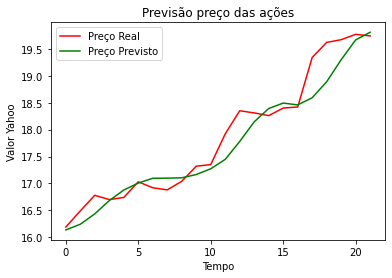

In [46]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço Real')
plt.plot(previsoes, color = 'green', label = 'Preço Previsto')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()